In [1]:
# import modules
import pandas as pd
import numpy as np
import string
import re
import spacy
import nltk
from string import punctuation
import csv

import matplotlib.pyplot as plt

from collections import Counter
from typing import List

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text 
# from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.metrics.pairwise import cosine_similarity

import networkx as nx


# Load in dataset and reformat

In [2]:

# set the file path for scraped jobs 
file_path = 'swe_us_ft_4wks_041923.csv'

# read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

df

,title,company,location,salary,link,descriptions
0,Software Engineer,Mavis Discount Tire,"Millwood, NY 10546","$100,000 - $130,000 a year",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Mavis Discount Tire - Software Engineer\nMavis...
1,Software Engineer (TS/SCI W/ CI Poly),Recro LLC,"Dulles, VA","$150,000 - $200,000 a year",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Recro is looking for a motivated, career and c..."
2,Sr. Software Engineer | MES Solutions,RedViking,"Hybrid remote in Plymouth, MI 48170",Estimated $119K - $150K a year,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Description:Are you ready to leverage new tech...
3,Senior Software Engineer (C++/Python) for Scie...,Block Engineering,"Hybrid remote in Southborough, MA 01772","$150,000 - $200,000 a year",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Block Engineering is a leading developer of la...
4,SEO/PPC Specialist,The AD Leaf Marketing Firm LLC.,"Melbourne, FL 32935",$16 - $19 an hour,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"We are a growing team of top-notch, innovative..."
...,...,...,...,...,...,...
93,Adept Software Engineer,CBT Nuggets,"Remote in Eugene, OR 97401","$100,000 - $150,000 a year",https://www.indeed.com/rc/clk?jk=45d2e48f422a8...,Why CBT Nuggets is a great place to work:\n\nW...
94,Software Engineer,Resourcely,Remote,Estimated $108K - $137K a year,https://www.indeed.com/rc/clk?jk=f9adce41f34a3...,Job Description\nWe're building software that ...
95,"Staff Software Engineer, Frontend",Recruit4Work S.L.,Remote,Estimated $150K - $190K a year,https://www.indeed.com/rc/clk?jk=8fc589205220e...,My client is seeking to appoint a sensational ...
96,Backend Engineer,"Polygon.io, Inc",Remote,Estimated $119K - $151K a year,https://www.indeed.com/rc/clk?jk=6aaec5092396c...,About this role\nWe are seeking a high perform...


In [3]:

# find type of work (remote, hybrid, or inperson) and state if applicable
work_week = []

for loc in df['location']:
    state_match = re.findall(r'(?<![A-Z])[A-Z]{2}(?![A-Z])', loc)
    
    if 'hybrid' in loc.lower():
        job_type = 'hybrid'
    elif 'remote' in loc.lower():
        job_type = 'remote'
        state_match = ['remote']
    else:
        job_type = 'in-person'
        
    work_week.append((job_type,state_match[0]))
    
df['type'], df['location'] = zip(*work_week)

# reformat salary column to avg annual
hrs_per_year = 40*52
salary = []

for s in df['salary']:
    if type(s) == str and any(ch.isdigit() for ch in s):
        # Define the regular expression pattern to match salary ranges
        pattern = r'\$([\d,]+)'
        # Use regular expression to extract the lower and upper bound of the salary range
        match = re.findall(pattern, s.replace(',',''))
        avg_salary = sum([int(m) for m in match])/len(match)
        # adjust to annual
        if 'an hour' in s:
            avg_salary = avg_salary*hrs_per_year
        if 'month' in s:
            avg_salary = avg_salary*12
        if 'Estimated' in s:
            avg_salary = avg_salary*1000
        
        s = avg_salary
        
    salary.append(s)

df['salary'] = salary

df


,title,company,location,salary,link,descriptions,type
0,Software Engineer,Mavis Discount Tire,NY,115000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Mavis Discount Tire - Software Engineer\nMavis...,in-person
1,Software Engineer (TS/SCI W/ CI Poly),Recro LLC,VA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Recro is looking for a motivated, career and c...",in-person
2,Sr. Software Engineer | MES Solutions,RedViking,MI,134500.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Description:Are you ready to leverage new tech...,hybrid
3,Senior Software Engineer (C++/Python) for Scie...,Block Engineering,MA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Block Engineering is a leading developer of la...,hybrid
4,SEO/PPC Specialist,The AD Leaf Marketing Firm LLC.,FL,36400.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"We are a growing team of top-notch, innovative...",in-person
...,...,...,...,...,...,...,...
93,Adept Software Engineer,CBT Nuggets,remote,125000.0,https://www.indeed.com/rc/clk?jk=45d2e48f422a8...,Why CBT Nuggets is a great place to work:\n\nW...,remote
94,Software Engineer,Resourcely,remote,122500.0,https://www.indeed.com/rc/clk?jk=f9adce41f34a3...,Job Description\nWe're building software that ...,remote
95,"Staff Software Engineer, Frontend",Recruit4Work S.L.,remote,170000.0,https://www.indeed.com/rc/clk?jk=8fc589205220e...,My client is seeking to appoint a sensational ...,remote
96,Backend Engineer,"Polygon.io, Inc",remote,135000.0,https://www.indeed.com/rc/clk?jk=6aaec5092396c...,About this role\nWe are seeking a high perform...,remote


In [4]:
states = 'AL, AK, AZ, AR, CA, CO, CT, DE, DC, FL, GA, HI, ID, IL, IN, IA, KS, KY, LA, ME, MD, \
MA, MI, MN, MS, MO, MT, NE, NV, NH, NJ, NM, NY, NC, ND, OH, OK, OR, PA, PR, RI, SC, \
SD, TN, TX, UT, VT, VA, WA, WV, WI, WY'.split(', ')

annual_mean_wage = pd.read_csv('mean_annual_salary_swe.csv').loc[:51]
annual_mean_wage['Area Name'] = pd.Series(states)

# get US mean salary then convert state salary stats to dict with {state:avg_salary}
us_avg_salary = round(annual_mean_wage['Annual mean wage'].mean(), 0)
annual_mean_wage = dict(zip(annual_mean_wage.iloc[:,0],annual_mean_wage.iloc[:,1]))

# calculate salary difference in comparison to location average
salary_delta = []
for i,location in enumerate(df['location']):
    salary = df['salary'][i]
    # if salary is known
    if type(salary) != 'str':
        # if remote, take difference from US average, else use state average
        if location != 'remote':
            salary_delta.append(salary-annual_mean_wage[location])
        else:
            salary_delta.append(salary-us_avg_salary)
    else:
        salary_delta.append(salary)

df['salary_delta'] = salary_delta
df


,title,company,location,salary,link,descriptions,type,salary_delta
0,Software Engineer,Mavis Discount Tire,NY,115000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Mavis Discount Tire - Software Engineer\nMavis...,in-person,-14950.0
1,Software Engineer (TS/SCI W/ CI Poly),Recro LLC,VA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Recro is looking for a motivated, career and c...",in-person,47170.0
2,Sr. Software Engineer | MES Solutions,RedViking,MI,134500.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Description:Are you ready to leverage new tech...,hybrid,36770.0
3,Senior Software Engineer (C++/Python) for Scie...,Block Engineering,MA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Block Engineering is a leading developer of la...,hybrid,46810.0
4,SEO/PPC Specialist,The AD Leaf Marketing Firm LLC.,FL,36400.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"We are a growing team of top-notch, innovative...",in-person,-68800.0
...,...,...,...,...,...,...,...,...
93,Adept Software Engineer,CBT Nuggets,remote,125000.0,https://www.indeed.com/rc/clk?jk=45d2e48f422a8...,Why CBT Nuggets is a great place to work:\n\nW...,remote,17979.0
94,Software Engineer,Resourcely,remote,122500.0,https://www.indeed.com/rc/clk?jk=f9adce41f34a3...,Job Description\nWe're building software that ...,remote,15479.0
95,"Staff Software Engineer, Frontend",Recruit4Work S.L.,remote,170000.0,https://www.indeed.com/rc/clk?jk=8fc589205220e...,My client is seeking to appoint a sensational ...,remote,62979.0
96,Backend Engineer,"Polygon.io, Inc",remote,135000.0,https://www.indeed.com/rc/clk?jk=6aaec5092396c...,About this role\nWe are seeking a high perform...,remote,27979.0


# Tokenize

In [5]:
def tokenize_a_doc(doc, nlp, lemmatized=True, remove_stopword=True, remove_punct=True): 
    clean_tokens = []
    # load current doc into spacy nlp model and split sentences by newline chars
    sentences = doc.split("\n")
    for sentence in sentences:
        doc = nlp(sentence)
        # clean either lemmatized unigrams or unmodified doc tokens
        if lemmatized:
            clean_tokens += [token.lemma_.lower() for token in doc            # using spacy nlp params, skip token if:
                            if (not remove_stopword or not token.is_stop)     # it is a stopword and remove_stopwords = True
                            and (not remove_punct or not token.is_punct)      # it is punctuation and remove_punct = True
                            and not token.lemma_.isspace()]                   # it is whitespace                               
        else:
            clean_tokens += [token.text.lower() for token in doc 
                            if (not remove_stopword or not token.is_stop) 
                            and (not remove_punct or not token.is_punct) 
                            and not token.text.isspace()]
    return clean_tokens

def tokenize(docs, lemmatized=True, remove_stopword=True, remove_punct=True):
    # load in spacy NLP model and disable unused pipelines to reduce processing time/memory space
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    nlp.add_pipe("sentencizer")
    # tokenize each doc in the corpus using specified params for lemmatization and removal conditions
    tokens = [tokenize_a_doc(doc, nlp, lemmatized, remove_stopword, remove_punct) for doc in docs]
     # drop terms that appear in at least 80 docs, or 5 docs or less, and additional stop words
    add_stop = ['e.g.']
    tokens = drop_top_and_bottom(tokens, 80, 5, add_stop)  
    return tokens


def drop_top_and_bottom(tokens, top, bot, add_stop):
    docs_tokens = {idx:nltk.FreqDist(tokens) for idx,tokens in enumerate(tokens)}
    dtm=pd.DataFrame.from_dict(docs_tokens, orient="index").fillna(0).sort_index(axis = 0)
    docs_per_term = dtm.astype(bool).sum(axis=0)

    tokens = [[token for token in t if (docs_per_term[token] > bot and docs_per_term[token] < top 
                                        and token not in add_stop)] for t in tokens]
    
    return tokens

tokens = tokenize(df['descriptions'], lemmatized=True, remove_stopword=True, remove_punct=True)
df['cleaned_desc'] = pd.Series(tokens).apply(lambda x: " ".join(x))


df


,title,company,location,salary,link,descriptions,type,salary_delta,cleaned_desc
0,Software Engineer,Mavis Discount Tire,NY,115000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Mavis Discount Tire - Software Engineer\nMavis...,in-person,-14950.0,engineer large independently hold sale united ...
1,Software Engineer (TS/SCI W/ CI Poly),Recro LLC,VA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Recro is looking for a motivated, career and c...",in-person,47170.0,look motivated career customer orient engineer...
2,Sr. Software Engineer | MES Solutions,RedViking,MI,134500.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Description:Are you ready to leverage new tech...,hybrid,36770.0,description leverage new technology expand lea...
3,Senior Software Engineer (C++/Python) for Scie...,Block Engineering,MA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Block Engineering is a leading developer of la...,hybrid,46810.0,engineering lead developer base system proud i...
4,SEO/PPC Specialist,The AD Leaf Marketing Firm LLC.,FL,36400.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"We are a growing team of top-notch, innovative...",in-person,-68800.0,grow innovative highly detail orient professio...
...,...,...,...,...,...,...,...,...,...
93,Adept Software Engineer,CBT Nuggets,remote,125000.0,https://www.indeed.com/rc/clk?jk=45d2e48f422a8...,Why CBT Nuggets is a great place to work:\n\nW...,remote,17979.0,great place office remotely united states life...
94,Software Engineer,Resourcely,remote,122500.0,https://www.indeed.com/rc/clk?jk=f9adce41f34a3...,Job Description\nWe're building software that ...,remote,15479.0,job description build empower user create secu...
95,"Staff Software Engineer, Frontend",Recruit4Work S.L.,remote,170000.0,https://www.indeed.com/rc/clk?jk=8fc589205220e...,My client is seeking to appoint a sensational ...,remote,62979.0,client seek staff engineer frontend help shape...
96,Backend Engineer,"Polygon.io, Inc",remote,135000.0,https://www.indeed.com/rc/clk?jk=6aaec5092396c...,About this role\nWe are seeking a high perform...,remote,27979.0,role seek high perform backend engineer help b...


# N-grams

In [6]:

# find k most popular n-grams
def most_popular_ngrams(corpus, n, top_k):
    # Create a TfidfVectorizer with n-grams
    params = {
        'ngram_range':n,
        'smooth_idf':True
    }
    vectorizer = TfidfVectorizer(**params)
    
    # get term-document matrix
    tfidf_matrix = vectorizer.fit_transform(corpus)
    smoothed_tfidf = tfidf_matrix.toarray()
    
    # Calculate the average score for each n-gram
    avg_score = np.mean(smoothed_tfidf, axis=0)
    
    # Get the top-k n-grams based on their average TF-IDF scores
    ngrams = vectorizer.get_feature_names_out()
    top_ngrams = sorted(zip(ngrams, avg_score), key=lambda x: x[1], reverse=True)[:top_k]
    top_ngrams_list = [ngram for ngram, score in top_ngrams]
    
    return top_ngrams_list, pd.DataFrame(smoothed_tfidf, columns = ngrams)


# Semantic Networks

Top 20 1-grams:
 
['application', 'design', 'insurance', 'build', 'system', 'product', 'code', 'company', 'technology', 'engineer', 'develop', 'pay', 'time', 'ability', 'job', 'skill', 'solution', 'knowledge', 'opportunity', 'web']

Node size - max size in graph: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


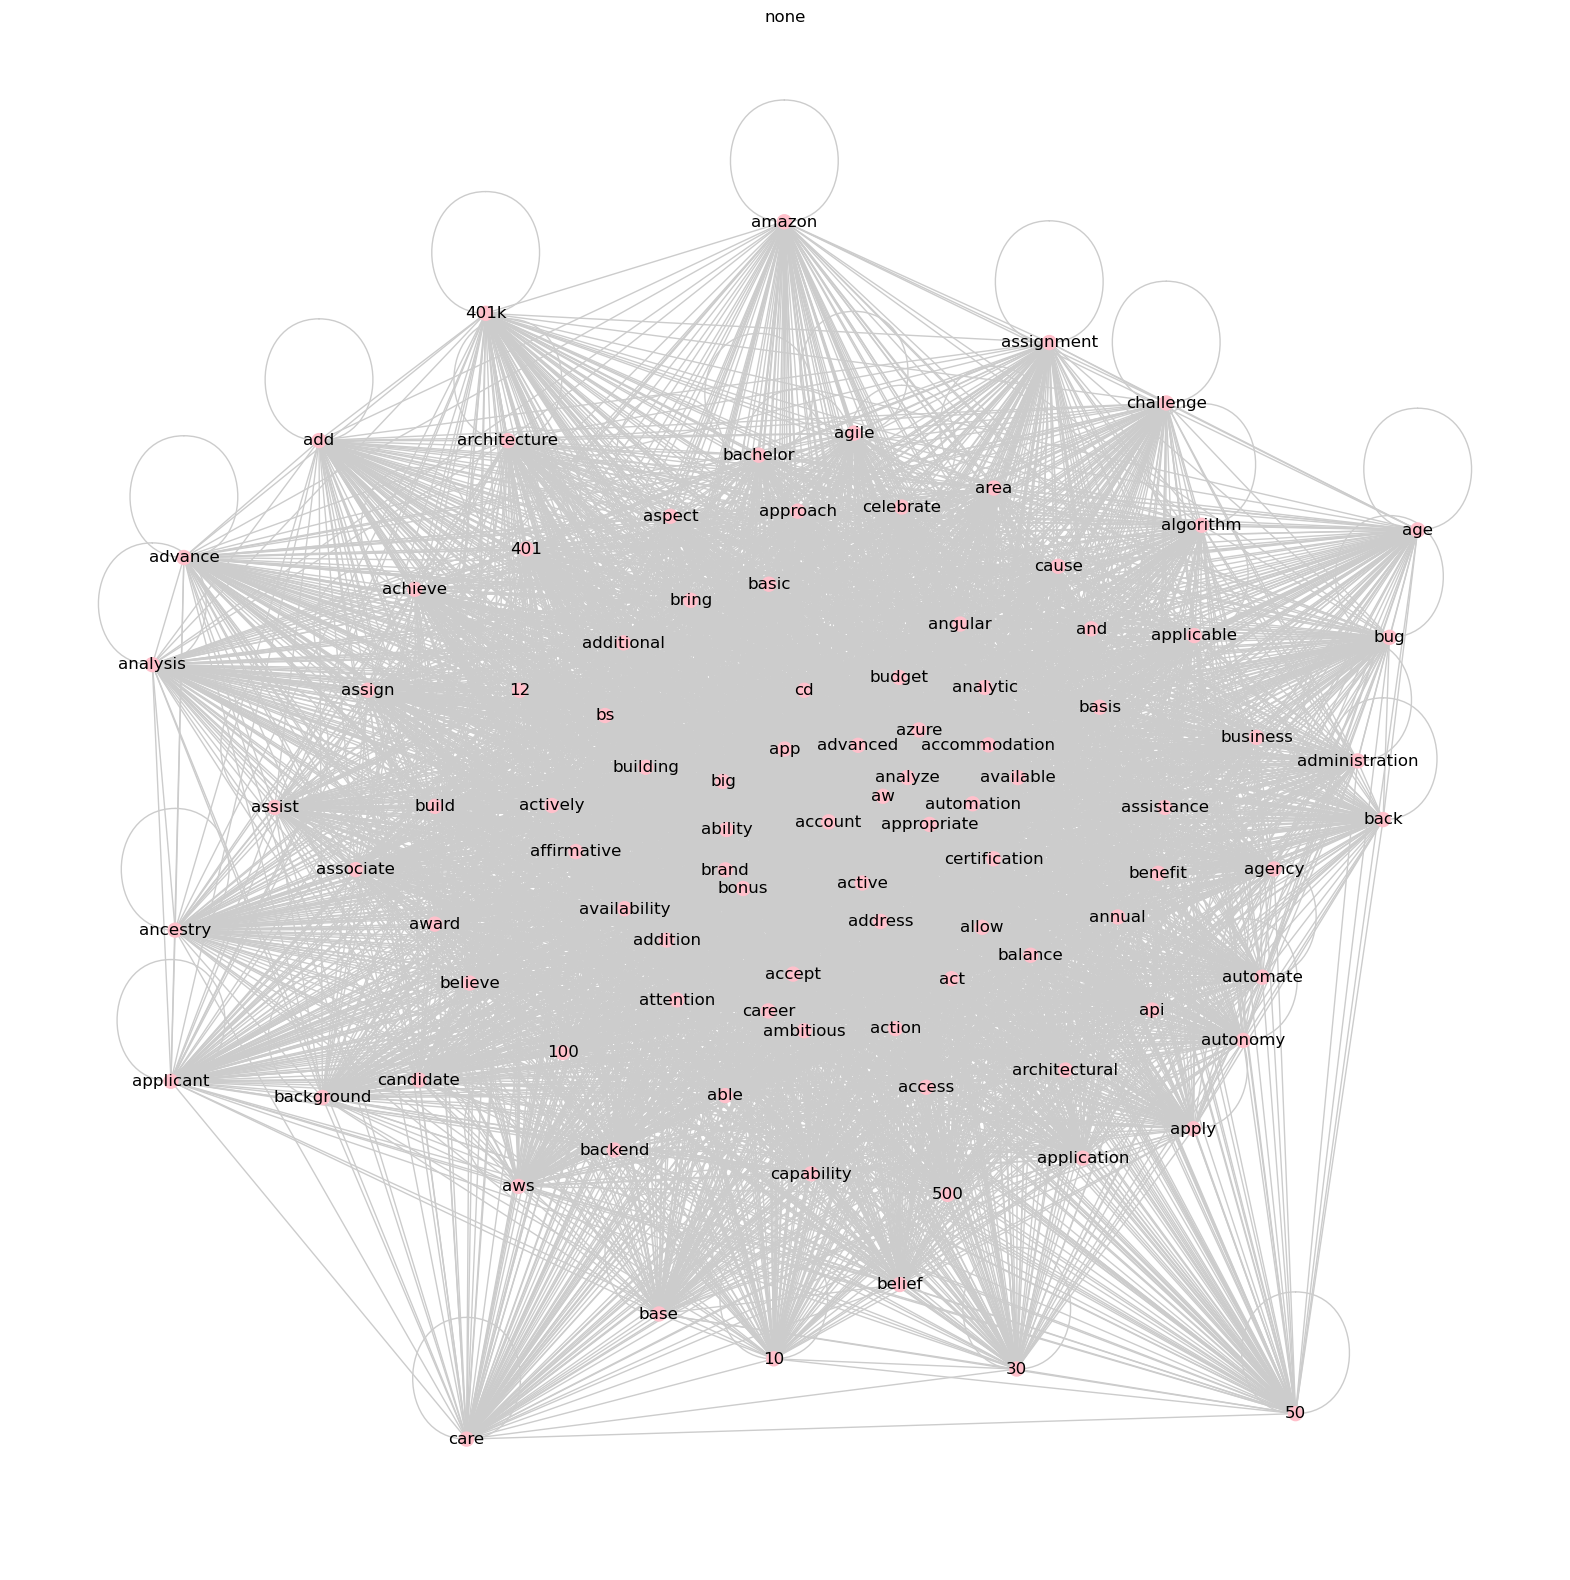

In [20]:
# show semantic network
n = 1
top_k = 20
popular_phrases, smoothed_tfidf_ngrams = most_popular_ngrams(df['cleaned_desc'], (n,n), top_k)
print(f'Top {top_k} {n}-grams:\n \n{popular_phrases}\n')

# Compute cosine similarity between smoothed TF-IDF vectors
similarity_matrix = cosine_similarity(smoothed_tfidf_ngrams)

# Create a semantic network as a graph
G = nx.Graph()
G = nx.from_numpy_matrix(similarity_matrix, create_using=nx.Graph()) # creating from adjacency matrix 
node_name = dict(zip(range(0,len(list(G.nodes()))), smoothed_tfidf_ngrams.columns))  
G = nx.relabel_nodes(G, node_name)

# Take a look
plt.figure(figsize=(20,20), dpi=100)

# node size proportional to eigenvector centrality of words
node_size= [x*1000 for x in nx.eigenvector_centrality(G).values()]
mag = [node - max(node_size) for node in node_size]
print(f'Node size - max size in graph: {mag}')
# choose a layout function
pos=nx.kamada_kawai_layout(G)

# edge color
edge_color='0.8'

nx.drawing.nx_pylab.draw_networkx(G,
                                  node_size=node_size, 
                                  node_color = "pink",
                                  pos=pos,
                                  edge_color=edge_color,
                                  with_labels=True,
                                 font_size=12)
plt.title('none')
plt.axis("off") 
plt.show()

Top 20 3-grams:
 
['degree computer science', 'job type time', 'equal opportunity employer', 'type time pay', 'insurance pay time', 'time pay benefit', 'schedule hour shift', 'bachelor degree computer', 'pay benefit 401', 'medical dental vision', 'remote health insurance', 'computer science related', 'vision insurance schedule', 'location remote health', 'shift monday friday', '401 matching dental', 'matching dental insurance', 'science related field', '401 401 matching', 'benefit 401 401']

Node size - max size in graph: [-29.396079934459266, -66.97260458771726, -99.91288888122222, -30.271220220901228, -25.028195936719698, -11.187062393987276, -67.23749316741142, -43.238355573920416, -98.32469705097198, -93.09754275803499, -89.6079121134862, -73.73444416082091, -123.34385512344949, -155.72303358521444, -68.33423050694087, -134.07784221968745, -134.40796812876675, -60.381015691984544, -27.06720004165703, -18.23501094652707, -152.75895284080744, -52.68370672725307, -116.64408508253086, 

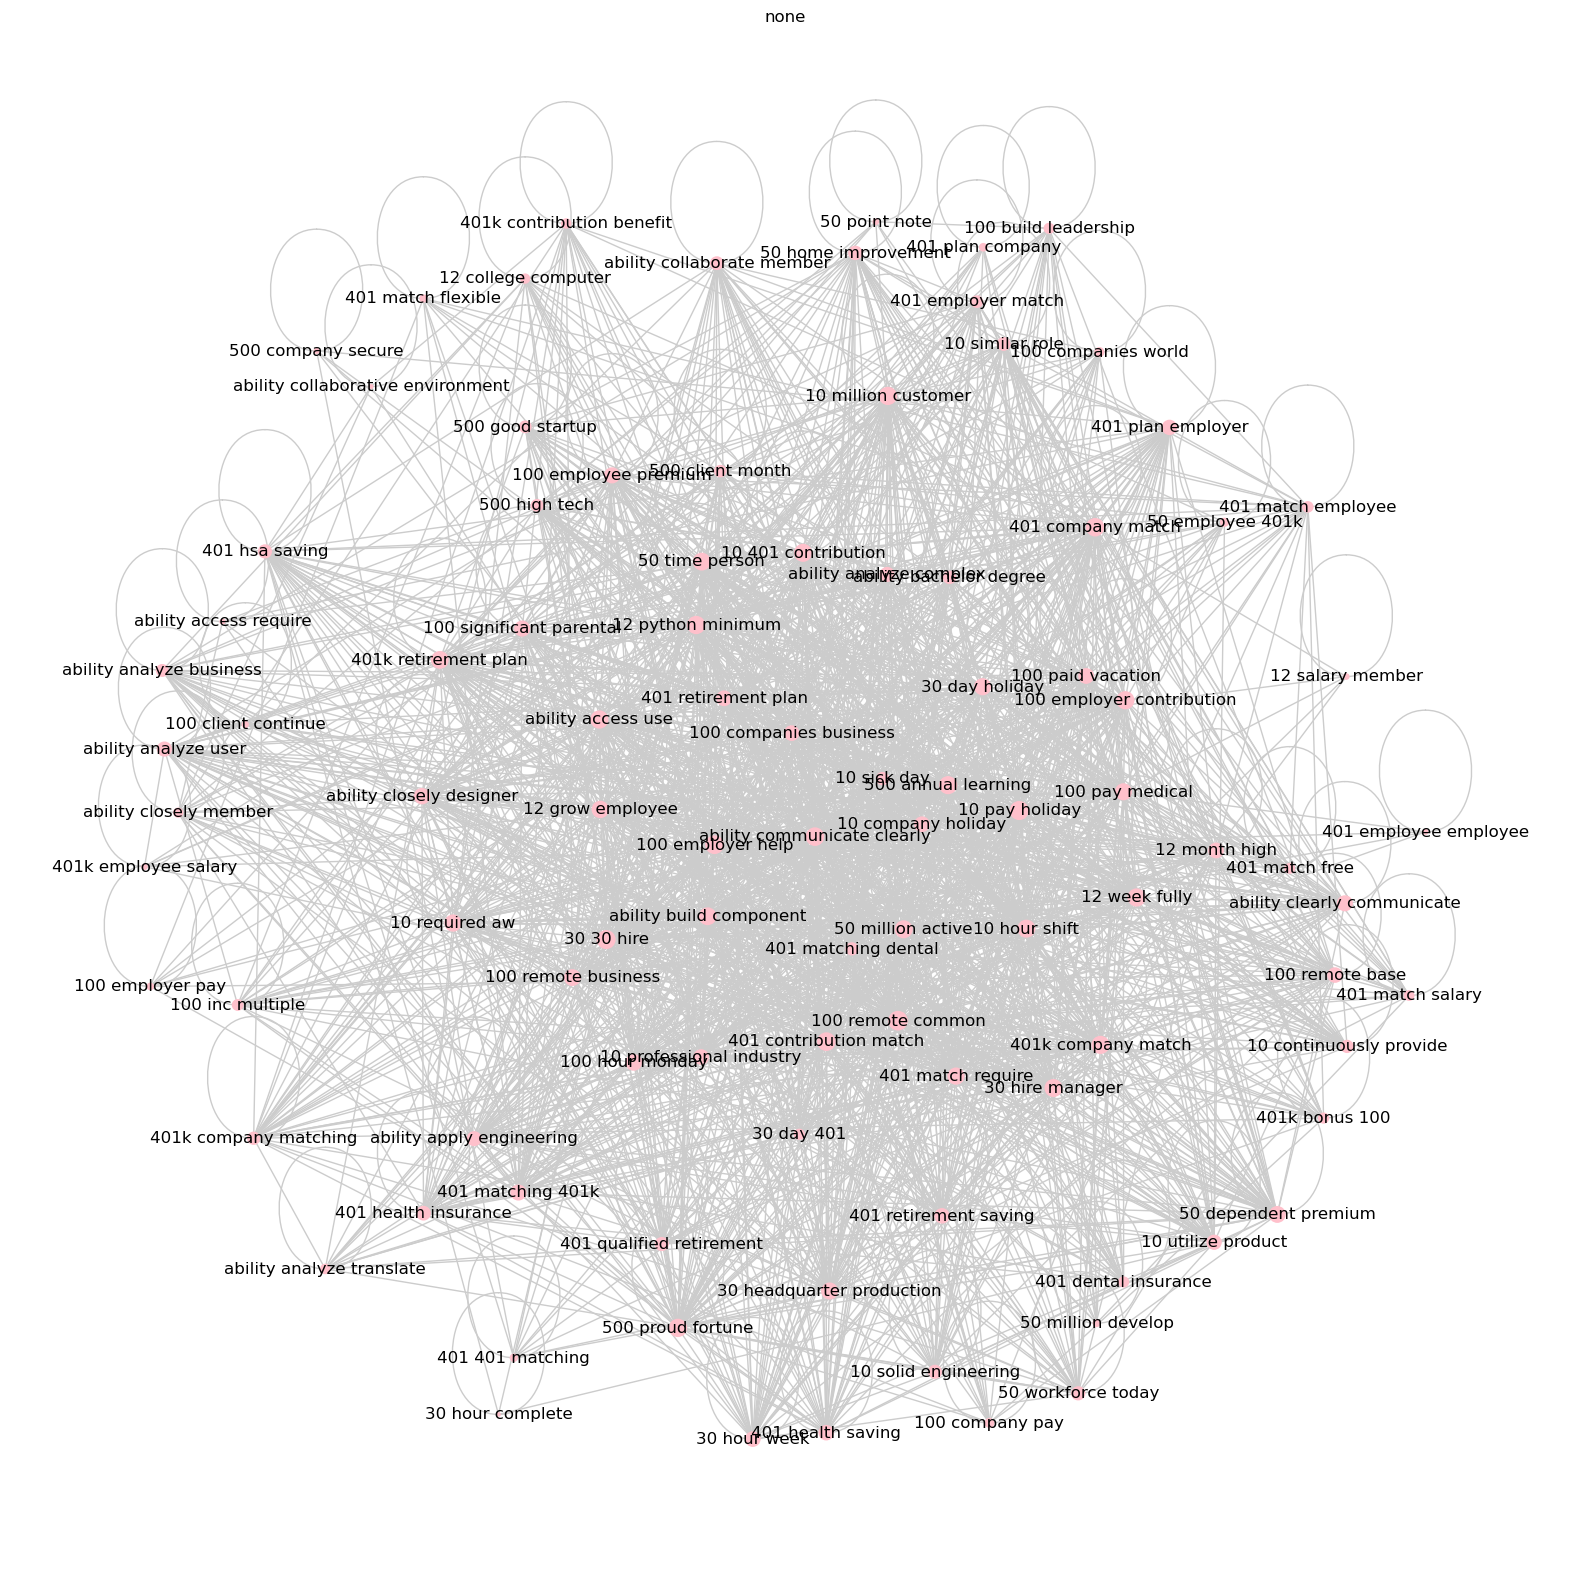

In [11]:
# show semantic network


n = 3
top_k = 20
popular_phrases, smoothed_tfidf_ngrams = most_popular_ngrams(df['cleaned_desc'], (n,n), top_k)
print(f'Top {top_k} {n}-grams:\n \n{popular_phrases}\n')

# Compute cosine similarity between smoothed TF-IDF vectors
similarity_matrix = cosine_similarity(smoothed_tfidf_ngrams)

# Create a semantic network as a graph
G = nx.Graph()
G = nx.from_numpy_matrix(similarity_matrix, create_using=nx.Graph()) # creating from adjacency matrix 
node_name = dict(zip(range(0,len(list(G.nodes()))), smoothed_tfidf_ngrams.columns))  
G = nx.relabel_nodes(G, node_name)

# Take a look
plt.figure(figsize=(20,20), dpi=100)

# node size proportional to eigenvector centrality of words
node_size= [x*1000 for x in nx.eigenvector_centrality(G).values()]
mag = [node - max(node_size) for node in node_size]
print(f'Node size - max size in graph: {mag}')
# choose a layout function
pos = nx.spring_layout(G, k=0.4)
# edge color
edge_color='0.8'

nx.drawing.nx_pylab.draw_networkx(G,
                                  node_size=node_size, 
                                  node_color = "pink",
                                  pos=pos,
                                  edge_color=edge_color,
                                  with_labels=True,
                                 font_size=12)
plt.title('none')
plt.axis("off") 
plt.show()

# Find most popular skills

In [9]:

def most_popular_skills(phrases, skills, n):
    vectorizer = CountVectorizer().fit_transform(phrases + skills)
    similarity_matrix = cosine_similarity(vectorizer)[:len(phrases), len(phrases):]
    
    average_similarities = np.mean(similarity_matrix, axis=0)
    sorted_indices = np.argsort(average_similarities)[::-1]
    
    popular_elements = [skills[i] for i in sorted_indices[:n]]
    return popular_elements


tech_skills = pd.read_csv('Hot_Technologies_Software_Developer_ONET.csv')
tech_skills = tech_skills.loc[tech_skills['In Demand'] == 'Yes']
tech_skill_names = tech_skills['Technology Skill'].apply(lambda x: x.lower().replace('software','')).to_list()

soft_skills = pd.read_csv('soft_skills.csv')
soft_skill_names = soft_skills['skill_name']

n = 20
most_popular = most_popular_skills(popular_phrases, tech_skill_names, n)
print(f'\nTop {n} popular technical skills based on top n-grams: \n{most_popular}')


most_popular = most_popular_skills(popular_phrases, list(soft_skill_names), n)
print(f'\nTop {n} popular soft skills based on top n-grams: \n{most_popular}')




Top 20 popular technical skills based on top n-grams: 
['unix', 'kubernetes', 'structured query language sql', 'javascript', 'python', 'amazon web services aws ', 'c#', 'microsoft azure ', 'git', 'google angular', 'react', 'cascading style sheets css', 'docker', 'linux', 'c++', 'hypertext markup language html', 'microsoft sql server', 'jenkins ci', 'node.js', 'nosql']

Top 20 popular soft skills based on top n-grams: 
['time management', 'time management skills', 'manages time effectively', 'ability to manage time', 'ability to work within time limits', 'ability to work within strict time', 'ability to work within time frames', 'ability to deliever tasks on time', 'ability to work with time limitations', 'ability to work under time pressure', 'ability to keep within time limits', 'willing to work under time pressure', 'able to work under time tight constraints', 'ability to work within strict time frames', 'ability to work with limited time frame', 'flexibility to work within strict t